분류 Classification - 분류의 측정 척도 점검

라벨이 두개인 이진 분류의 경우

1. 정확도 = 예측결과가 동일한 데이터 건수 / 전체 데이터 건수
정확도는 이진 분류 (라벨이 0 또는 1 / 생존 또는 사망 / 참 또는 거짓으로 되는 분류) 에서는 잘 사용되지 않음
너무 랜덤성이 강함 : 작정하고 pred 가 00000만 나오는 모델이라 할지라도 우연찮게 y_test 가 0이 80%면 모델 정확도도 80% 나옴

In [61]:
# 1. 정확도 metric 의 문제 예시 : test 레이블에 우연히 pred 값이 많으면 그냥 정확도도 높게 나옴...
# 밑에 dummyClassifier는 그냥 0만 내뱉는 무의미한 분류기인데도 불구하고 test 레이블에 0이 많으므로 정확도도 90%...

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator

class dummyClassifier(BaseEstimator):

    def fit(self, x, y= None):
        pass

    def predict(self, x):
        pred = np.zeros((len(x), 1))
        return pred
    
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

digits = load_digits()
features = digits.data
label = digits.target

# boolean 을 True면 1 False면 0으로 바꾸는 신기한 방법

label = (label==7).astype(int)

X_train, X_test, Y_train, y_test = train_test_split(features, label, train_size = 0.2, random_state = 0)

my_clf = dummyClassifier()
my_clf.fit(X_train, Y_train)

pred = my_clf.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9026425591098748

In [ ]:
# 타이타닉 raw 데이터 
# -> 1) 전처리(na 작업 (채우기 및 N) / 임의로 바꿔주기 / 필요없는 피처 삭제 / 특정 피처 LabelEncoder / 특정 숫자 Scaler)
# -> 2) 피처와 라벨 분리
# -> 3) 학습과 테스트 데이터 분리
# -> 4) 모델 학습(KFold), 모델 하이퍼파라메터 최적화 등 -> 최적 모델 선택
# -> 5) 모델.fit() -> 모델.predict()
# -> *** 6) 예측값에 대한 검증

import pandas as pd
import numpy as np

df_data = pd.read_csv("C:/Users/kanld/Desktop/allPractice/머신러닝_강의/titanic_train.csv")

from sklearn.preprocessing import LabelEncoder

def fill_na(df_column):
    try:
        df_column = df_column.fillna(df_column.mean())
    except:
        df_column = df_column.fillna(method = 'ffill')
    return df_column

def encoding_cat_feature(feature_array):
    lb = LabelEncoder()
    lb.fit(feature_array)
    res = lb.transform(feature_array)
    return res

def cabin_first_word(df):
    df['Cabin'] = df['Cabin'].str[:1]
    return df

def needed_data_only(df, column_list:list):
    df = df[column_list]
    return df

def preprocess(df, encoding_list = ['Sex', 'Cabin', 'Embarked']):
    df['Cabin'].fillna("N", inplace = True)
    df = needed_data_only(df, column_list = ['Pclass', 'Survived', 'Sex', 'Age', 'Cabin', 'Embarked'])
    df = df.apply(fill_na, axis = 0)
    df = cabin_first_word(df)
    df[encoding_list] = df[encoding_list].apply(encoding_cat_feature)

    return df

df_data = preprocess(df_data)

df_feature = df_data.drop(columns = ['Survived'])
df_label = df_data[['Survived']]

# 학습, 테스트 분리

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, y_test = train_test_split(df_feature, df_label, \
                                                    test_size = 0.2, random_state = 11)

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver = 'liblinear', )

from sklearn.model_selection import GridSearchCV

params_lr_clf = {"solver" : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
grid_lr_clf = GridSearchCV(lr_clf, param_grid= params_lr_clf, scoring = 'accuracy', refit = True)

grid_lr_clf.fit(X_train, Y_train)
pred = grid_lr_clf.predict(X_test)

print(pred, grid_lr_clf.best_params_, grid_lr_clf.best_score_)

2. 오차 행렬 = 일치여부만 확인하는게 아니라 1종 오류 (False Positive) / 2종 오류 (True Negative) 까지 고려한 4분면으로 접근

(실제라벨, 예측결과)
Negative Negative = TN : 0, 0 | Negative Positive = FP : 0, 1
Positive Negative = FN : 1, 0 | Positive Positive = TP : 1, 1

* accuracy_score = 정확도 = (TN + FP) / 전체

3. precision_score = 정밀도 = TP / (FP + TP) -> 예측 Positive 중에 예측 = 실제 Positive -> 모델이 예측한 것 중에 실제로 얼마나 잘 맞췄는가?
-> 모델이 실제를 얼마나 잘 <b>예측하나?</b>

4. recall_score = 재현율 = TP / (FN + TP) -> 실제 Positive 중에 예측 = 실제 Positive -> 실제 양성중에 모델이 어느 정도나 반영하여 예측하나?
-> 모델이 실제를 얼마나 잘 <b>반영하나?</b> (실제값이 500개인데 모델이 50개만 predict 하면 아무리 그 50개가 전부 적중한다 하더라도 실제를 제대로 반영하지 못함)

정밀도와 재현율의 맹점

정밀도를 임의로 올리는 법 : 예측을 최대한 보수적으로 하면 됨 -> 정말 제일 확실해보이는 하나만 positive 로 predict 실시 -> 적중시 : 1/(TP = 1 + FP = 0) = 100%
재현율을 임의로 올리는 법 : 예측을 최대한 공격적으로 하면 됨 -> 100명의 환자 모두를 positive 로 predict 실시 ->
(실제 환자 수) 67 / (TP = 67 + FN = 0) = 100%

5. f1_score : 정밀도와 재현율의 tradeoff 및 각각이 가지고 있는 단점을 고려하여 정밀도와 재현율의 중간 수준에서 결정되는 값을 (0 ~ 1) 로 치환한 metric
f1_score = 2 * (정밀도 x 재현율) / (정밀도 + 재현율)

6. ROC 곡선의 Area Under Curve 값</p>
ROC곡선 : 실제 양성을 최대한 많이 찾는게 (=재현율)) 특히 중요한 경우에 사용 
</p>-> 100명이 무고하더라도 한놈의 스파이 색출/ 100명 음성이라도 한명 양성 찾는게 중요 등등
</p>-> 거꾸로 무고한걸 최대한 걸러내야 하는 경우 (스팸메일 100개 필터링 못하더라도 중요한 메일 유지하는게 더 중요) AUC의 중요성 감퇴

분류기의 임계값이 낮아질수록 -> "1) Positive 증가하면서 재현율 증가하고 / 2) Positive 증가하면서 거짓양성도 증가" 표시

AUC : ROC곡선의 넓이를 말함 -> 클수록 <b>"거짓양성 최소화하면서 참양성 찾아내는 모델"</b> 로 해석


In [66]:
''' 1. 여기서 언급되는 이진분류에 대한 검증 종합 함수 (관련 이론 및 논의는 markdown에) '''

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

def get_clf_eval(Y_test, pred):

    confusion = confusion_matrix(Y_test, pred)
    accuracy = accuracy_score(Y_test, pred)
    precision = precision_score(Y_test, pred)
    recall = recall_score(Y_test, pred)
    f1 = f1_score(Y_test, pred)
    roc_auc = roc_auc_score(Y_test, pred)

    print("confusion_matrix:", confusion_matrix(Y_test, pred))
    print("accuracy:", accuracy_score(Y_test, pred))
    print("precision:", precision_score(Y_test, pred))
    print("recall:", recall_score(Y_test, pred))
    print("f1_score:", f1_score(Y_test, pred))
    print("roc_auc_score:", roc_auc_score(Y_test, pred))
    
    return dict(confusion = confusion, accuracy = accuracy, precision = precision, recall = recall, f1 = f1, roc_auc = roc_auc)


In [ ]:
# 2. Threshold 논의 : 분류의 예측은 각 피처마다 특정 결과에 대한 확률이 도출되고, 가장 높은 확률 (or 특정 기준을 만족하는 확률)을 가지는 결과를 선택
# 이진분류의 경우 그 양성/음성 선택에 대한 기준확률이 하나밖에 없으므로 해당 기준확률(임계점) 이상의 경우 전부 양성

pred_proba = grid_lr_clf.predict_proba(X_test) # predict 의 각 결과에 대한 확률 array ([음성, 양성]) 도출
pred_concat = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)

# 예측된 양성일 확률
positive_proba = pred_proba[:, 1].reshape(-1, 1)

# 임의의 각 임계값에 대한 모델의 예측 검증

from sklearn.preprocessing import Binarizer
thresholds = [i * 0.1 for i in range(1, 10)]

def get_eval_by_threshold(y_test, pred_proba, thresholds:list):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold)
        binarizer.fit(pred_proba)
        pred_chgd = binarizer.transform(pred_proba)
        print(get_clf_eval(y_test, pred_chgd))

# get_eval_by_threshold(Y_test, positive_proba, thresholds)

# -------------------------

# 위짓거리를 한번에 구현한게 precision_recall_curve : precision 과 recall 점수를 임의의 interval로 생성한
# threshold 별로 뱉어냄

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, positive_proba, drop_intermediate = True)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(threshold, np.column_stack((precision[0:threshold.shape[0]], recall[0:threshold.shape[0]])), label = ['precision', 'recall'])
ax.legend()
ax.grid()
ax.set_xlim(0, 1)

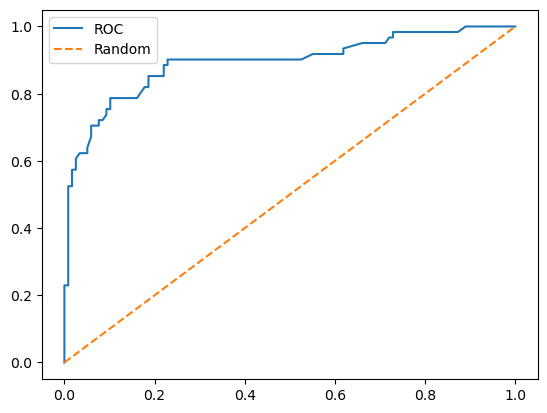

In [77]:
# 3. roc_auc_curve 그리기

from sklearn.metrics import roc_curve

positive_proba = pred_proba[:, 1].reshape(-1, 1)
fps, tps, thresholds = roc_curve(y_test, positive_proba)

def roc_curve_plot(y_test, pred_proba):
    fps, tps, thresholds = roc_curve(y_test, pred_proba)
    plt.plot(fps, tps, label = "ROC")
    plt.plot([0, 1], [0, 1], "--", label = "Random")
    plt.legend()
    plt.show()

roc_curve_plot(y_test, positive_proba)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Users/kanld/Desktop/allPractice/머신러닝_강의/diabetes.csv")

#1. 전처리

# df.describe() # > 해봤더니 이상한게 

# 1) min값이 0 -> 혈압 등등이 0??... 

features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[features].replace(0, df[features].mean())

#2) 피처별 단위가 다르므로 표준화
from sklearn.preprocessing import StandardScaler, MinMaxScaler
std_scaler = StandardScaler()
std_scaler.fit(df[features])
df[features] = std_scaler.transform(df[features])

minmax_scaler = MinMaxScaler()
df[['Age']] = minmax_scaler.fit_transform(df[['Age']])

#2. 피처, 라벨 분류
df_feature = df.drop(columns = ['Outcome'])
df_label = df[['Outcome']]

#3. 학습 / 테스트 분류

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_feature, df_label, test_size = 0.2, stratify = df_label)

#4. 학습 및 파라메터 조정

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lr_clf = LogisticRegression()
grid_lr_clf = GridSearchCV(lr_clf, param_grid = {}, cv = StratifiedKFold(5, shuffle = True), scoring='recall', refit = True)
grid_lr_clf.fit(X_train, y_train)
pred = grid_lr_clf.predict(X_test)
pred_proba = grid_lr_clf.predict_proba(X_test)[:, 1]

#6. 검증 metric 및 metric 시각화 툴

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

def get_clf_score(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print("confusion_matrix:", confusion_matrix(y_test, pred))
    print("accuracy:", accuracy_score(y_test, pred))
    print("precision:", precision_score(y_test, pred))
    print("recall:", recall_score(y_test, pred))
    print("f1_score:", f1_score(y_test, pred))
    print("roc_auc_score:", roc_auc_score(y_test, pred))
    
    return dict(confusion = confusion, accuracy = accuracy, precision = precision, recall = recall, f1 = f1, roc_auc = roc_auc)

def precision_recall_curve_plot(y_test, pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)
    fig, ax = plt.subplots(1, 1)
    ax.plot(thresholds, np.column_stack((precision[1:], recall[1:])), label = ['precision', 'recall'])
    ax.set_xlim(0, 1)
    ax.legend()

def roc_curve(y_test, pred):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
    plt.plot(fpr, tpr, label = "ROC")
    plt.plot([0, 1], [0, 1], "--", label = "Random")
    plt.legend()
    plt.show()

eval_res = get_clf_score(y_test, pred)


C:\Users\kanld\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kanld\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kanld\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kanld\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed w

confusion_matrix: [[91  9]
 [19 35]]
accuracy: 0.8181818181818182
precision: 0.7954545454545454
recall: 0.6481481481481481
f1_score: 0.7142857142857143
roc_auc_score: 0.7790740740740741
